In [ ]:
#|hide
#|default_exp data

# Data level

Reading and advance in data processing levels to be stored in netcdf database format.

```{note}
raw > l1a > l1b > l1c
```

In [ ]:
#|export
import os
import numpy as np
import pandas as pd
import xarray as xr
import logging
from toolz import assoc_in, merge_with
import pkg_resources as pkg_res
import warnings

from trosat import sunpos as sp
from trosat.cfconv import read_cfjson

import pyrnet
pyrnet_version = pyrnet.__version__
import pyrnet.pyrnet
import pyrnet.utils
import pyrnet.logger
import pyrnet.reports
import pyrnet.qcrad

# logging setup
logging.basicConfig(
    filename='pyrnet.log',
    encoding='utf-8',
    level=logging.DEBUG,
    format='%(asctime)s %(name)s %(levelname)s:%(message)s'
)
logger = logging.getLogger(__name__)

In [ ]:
import matplotlib.pyplot as plt

## netCDF dataset operations


### Filename
Filename from config format string.

In [ ]:
#|export
def get_fname(ds, freq, period=None, timevar='time', sfx='nc', kind=None, station=None, config=None):
    config = get_config(config)
    if period is None:
        period = ds[timevar].values[-1] - ds[timevar].values[0]
        period = pd.to_timedelta(period).floor("s").isoformat()
    if kind is None:
        if ds.station.size==1:
            kind = 's'
            station = ds.station.values[0]
        else:
            kind = 'n'
            station = ds.station.size
    format_dict = dict(
        dt = pd.to_datetime(ds[timevar].values[0]),
        period = period,
        campaign = config["campaign"],
        kind = kind,
        station = int(station),
        level = ds.processing_level,
        freq = freq,
        collection = int(config["collection"]),
        sfx = sfx
    )
    return config["output"].format(**format_dict) 

### Update netcdf coverage metadata
Add and update ACDD covarge metadata to dataset

In [ ]:
#|export
def update_coverage_meta(ds, timevar='time'):
    """Update global attributes related to geospatial and time coverage
    """
    duration = ds[timevar].values[-1] - ds[timevar].values[0]
    resolution = np.mean(np.diff(ds[timevar].values))
    now = pd.to_datetime(np.datetime64("now"))
    gattrs = {
        'date_created': now.isoformat(),
        'geospatial_lat_min': np.nanmin(ds.lat.values),
        'geospatial_lat_max': np.nanmax(ds.lat.values),
        'geospatial_lat_units': 'degN',
        'geospatial_lon_min': np.nanmin(ds.lon.values),
        'geospatial_lon_max': np.nanmax(ds.lon.values),
        'geospatial_lon_units': 'degE',
        'time_coverage_start': pd.to_datetime(ds[timevar].values[0]).isoformat(),
        'time_coverage_end': pd.to_datetime(ds[timevar].values[-1]).isoformat(),
        'time_coverage_duration': pd.to_timedelta(duration).isoformat(),
        'time_coverage_resolution': pd.to_timedelta(resolution).isoformat(),
    }
    ds.attrs.update(gattrs)
    return ds


### Stretch resolution
Update encoding *scale_factor* and *add_offset* to use the full dtype resolution.

In [ ]:
#|export
def stretch_resolution(ds: xr.Dataset) -> xr.Dataset:
    """ Stretch variable resolution to full integer size,
    to not lose resolution after averaging ADC count data."""
    for var in ds:
        if "scale_factor" not in ds[var].encoding:
            continue
        if "valid_range" not in ds[var].attrs:
            continue
        dtype = ds[var].encoding['dtype']
        valid_range = ds[var].valid_range
        int_limit = np.iinfo(dtype).max
        scale_factor = ds[var].encoding['scale_factor']
        scale_factor_mod = int((int_limit-1)/valid_range[1])
        ds[var].encoding.update({
            "scale_factor": scale_factor / scale_factor_mod,
            "_FillValue": int_limit,
        })
        ds[var].attrs.update({
            "valid_range": valid_range * scale_factor_mod
        })
    return ds

### Write to netcdf
Ensure complete metadata and merge if needed before writing to netcdf.

In [ ]:
#|export
def to_netcdf(ds, fname, timevar="time"):
    """xarray to netcdf, but merge if exist
    """
    # save to netCDF4
    ds = update_coverage_meta(ds, timevar=timevar)
    ds.to_netcdf(fname,
                 encoding={timevar:{'dtype':'float64'}}) # for OpenDAP 2 compatibility
#|export
def to_netcdf_l1b(ds, fname, freq='1s', timevar="time"):
    """xarray to netcdf, but merge if exist
    """
    # merge if necessary
    if isinstance(ds, xr.Dataset):
        dslist = [ds]
    else:
        dslist = ds
    
    if os.path.exists(fname):
        ds1 = xr.load_dataset(fname)
        dslist.append(ds1)
        
    ds = merge_l1b(dslist, freq=freq, timevar=timevar)
    # save to netCDF4
    ds = update_coverage_meta(ds, timevar=timevar)
    
    if os.path.exists(fname): 
        os.remove(fname)
    ds.to_netcdf(fname,
                 encoding={timevar:{'dtype':'float64'}}) # for OpenDAP 2 compatibility

### Resample
Specialized (fast) resample methods, as xarray resample is sometimes very slow.

In [ ]:
#|export
def resample(ds, freq, methods='mean', kwargs={}):
    """ Resample xarray dataset using pandas for speed.
    https://github.com/pydata/xarray/issues/4498#issuecomment-706688398
    """
    if isinstance(methods,str):
        methods = [methods]

    dsr = ds.to_dataframe().resample(freq)
    dsouts = []
    for method in methods:
        # what we want (quickly), but in Pandas form
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            df_h = dsr.apply(method)
        # rebuild xarray dataset with attributes
        vals = []
        for c in df_h.columns:
            vals.append(
                xr.DataArray(data=df_h[c],
                             dims=['time'],
                             coords={'time': df_h.index},
                             attrs=ds[c].attrs)
            )
        dsouts.append(xr.Dataset(dict(zip(df_h.columns, vals)), attrs=ds.attrs))

    if len(dsouts) == 1:
        dsouts = dsouts[0]
    return dsouts

## Config 
Parse default config

In [ ]:
#|export
def get_config(config: dict|None = None) -> dict:
    """Read default config and merge with input config
    """

    fn_config = pkg_res.resource_filename("pyrnet", "share/pyrnet_config.json")
    default_config = pyrnet.utils.read_json(fn_config)
    if config is None:
        config = default_config
    config = {**default_config, **config}

    # add default files
    cfiles = {
        "file_cfmeta": "share/pyrnet_cfmeta.json",
        "file_calibration": "share/pyrnet_calibration.json",
        "file_mapping": "share/pyrnet_station_map.json",
        "file_gti_angles": "share/pyrnet_gti_angles.json",
        "file_site": "share/pyrnet_sites.json",
    }
    for fn in cfiles:
        if config[fn] is None:
            config[fn] =  pkg_res.resource_filename("pyrnet", cfiles[fn])
    return config

def get_sensor_config(sconfig: dict|None = None) -> dict:
    """ Read the sensor configuration from the default json file and merge if needed. 
    """
    fn_config = pkg_res.resource_filename("pyrnet", "share/pyrnet_sensor_config.json")
    default_config = pyrnet.utils.read_json(fn_config)
    if sconfig is None:
        sconfig = default_config
    sconfig = {**default_config, **sconfig}
    return sconfig

def get_cfmeta(config: dict|None = None) -> dict:
    """Read global and variable attributes and encoding from cfmeta.json
    """
    config= get_config(config)
    # parse the json file
    cfdict = read_cfjson(config["file_cfmeta"])
    # get global attributes:
    gattrs = cfdict['attributes']
    # apply config
    gattrs = {k:v.format_map(config) for k,v in gattrs.items()}
    # get variable attributes
    d = pyrnet.utils.get_var_attrs(cfdict)
    # split encoding attributes
    vattrs, vencode = pyrnet.utils.get_attrs_enc(d)
    return gattrs, vattrs, vencode

## Encoding
The encoding attributes are defined within the file PyrNet/share/pyrnet_cfmeta.json per default.

The netcdf packing of data is realized via the two attributes *scale_factor* and *add_offset*:
  ```unpacked_variable = scale_factor * packed_variable + add_offset```

In [ ]:
#|export
def calc_encoding(sconfig:dict, ADCV=3.3, ADCbits=10) -> dict:
    ADCfac = ADCV / (2**ADCbits-1) # Last bit is reserved 
    sencoding = {}
    for k, v in sconfig.items():
        sencoding.update(
            {k: dict(
                units=v['units'],
                scale_factor=v['C']*ADCfac/v['gain'],
                add_offset=v['offset'],
                valid_range= [0, min(((2**ADCbits-1), int(v['Vmax']*v['gain']/ADCfac)))]
            )}
        )
    return sencoding

In [ ]:
sconfig = get_sensor_config()
sencoding = calc_encoding(sconfig)
sencoding

{'ta': {'units': 'K',
  'scale_factor': 0.12903225806451613,
  'add_offset': 253.15,
  'valid_range': [0, 775]},
 'rh': {'units': '1',
  'scale_factor': 0.0012903225806451613,
  'add_offset': 0.0,
  'valid_range': [0, 775]},
 'battery_voltage': {'units': 'V',
  'scale_factor': 0.0064516129032258064,
  'add_offset': 0.0,
  'valid_range': [0, 992]},
 'ghi': {'units': 'V',
  'scale_factor': 1.075268817204301e-05,
  'add_offset': 0.0,
  'valid_range': [0, 1023]},
 'gti': {'units': 'V',
  'scale_factor': 1.075268817204301e-05,
  'add_offset': 0.0,
  'valid_range': [0, 1023]}}

In [ ]:
#|dropcode
#|dropout
fn_cfjson = pkg_res.resource_filename("pyrnet", "share/pyrnet_cfmeta.c01.json")
read_cfjson(fn_cfjson)

{'attributes': {'Conventions': 'CF-1.10, ACDD-1.3',
  'title': 'TROPOS pyranometer network (PyrNet) observational data set',
  'history': '',
  'institution': 'Leibniz Institute for Tropospheric Research (TROPOS)',
  'source': 'TROPOS pyranometer network (PyrNet)',
  'references': 'https://doi.org/10.5194/amt-9-1153-2016',
  'Department': 'Remote Sensing of Atmospheric Processes',
  'Department_team': 'Clouds, Aerosol and Radiation',
  'Address': 'Permoser Str. 15, 04318 Leipzig, Germany',
  'Contact_person': 'Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de',
  'Contributor_name': '{contributor_name}',
  'Contributor_role': '{contributor_role}',
  'Authors_software': 'Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de',
  'Creator_name': '{creator_name}',
  'Project': '{project}',
  'Standard_name_vocabulary': 'CF Standard Name Table v81',
  'License': 'CC-BY-SA 3.0'},
 'variables': {'ta': {'type': 'u2',
   

### Irradiance values

Irradiance values are stored as Voltage for later calibration. Assigning 1500Wm-2 as maximum measurable irradiance from the irradiance sensor. The maximum counts (*valid_max*) measured by the logger can be calculated by:
 * maximum counts = $\mathrm{gain}*1500*\mathrm{C_{max}}*1023/3.3$

Most calibration factors are in the area of 7.5 uV/Wm-2, assuming $\mathrm{C_{max}}=8$uV/Wm-2 for this estimate seems sufficient. All radiation sensors are amplified with a fixed gain of $\mathrm{gain}=300$.

Later (level 1c+) the scale factor will be instrument specific by adding the calibration from V to W m-2

### Temperature and humidity


Calibration coefficients for Temperature and Humidity DKRF-4000 series (discontinued) https://www.driesen-kern.de/downloads/produktlinie_feuchte.pdf are:
 * Temperature (T) range :-20-80 degC  from 0-5V
 * relative Humidity (rH) range: 0-100% from 0-5V

As the logger ADC range is 0-3.3V with a 10bit resolution, the sensors are measured through a voltage splitting circuit. Therefore, the ADC counts have to be doubled.
 * Voltage U [V] = $2* 3.3/1023$ [counts]
 * T = $-20 + 100*(U/5)$ [degC] = $253.15 + 100*(U/5)$ [K]
 * rH = $(U/5)$  [%]  = $(U/5)$    [%]

### Ancillary data

* solar zenith angle (*szen*)
    * valid range unpacked: (0,180) (deg)
    * packing in u2 integer (unsigned 16bit)
        * fill value = $2^{16} - 1$
        * scale_factor = $180 /(2^{16}-2)$
* solar azimuth angle (*sazi*)
    * valid range unpacked: (0,360)
    * packing in u2 integer (unsigned 16bit)
        * fill_value = $2^{16} -1$
        * scale_factor= $360 / (2^{16}-2)$
* earth sun distance (*esd*)
    * valid range unpacked: (0.98,1.02)
    * packing in u2 integer (unsigned 16bit)
        * fill_value = $2^{16} -1$
        * scale_factor= $(1.02-0.98)/(2^{16}-2)$
        * add_offset = 0.98


In [ ]:
#|dropcode
#|dropout
sensor_config = {
    "ta": {
        "C": 100./5., # K/V
        "offset": 253.15, # K at 0V
        "gain": 0.5, # measured over voltage splitter
        "Vmax": 5, # V output at sensor
    },
    "rh": {
        "C": 1./5., # 1/V
        "offset": 0, # 0 at 0V
        "gain": 0.5, # measured over voltage splitter
        "Vmax": 5, # V output at sensor
    },
    "battery": {
        "C": 1., # V(batt)/V
        "offset": 0, # V at 0V
        "gain": 0.5, # measured over voltage splitter
        "Vmax": 6.4, # V output at sensor
    },
    "radflux": {
        "C": 1., # Vsensor/Vmeasured
        "offset": 0, # V at 0V
        "gain": 300, # amplified
        "Vmax": 1500*8*1e-6, # V output at sensor
    },
}
ADCfac = 3.3/1023. # V/counts
for var in sensor_config:
    sconf = sensor_config[var]
    print(f"{var} scale_factor: {sconf['C']*ADCfac/sconf['gain']}")
    print(f"{var} add_offset: {sconf['offset']}")
    print(f"{var} valid_range: [0, {min((1023, int(sconf['Vmax']*sconf['gain']/ADCfac)))}]")
    print()

# szen encoding
print(f"scale_factor szen (deg): {180./(36_000)}")
print(f"add_offset szen: 0.0 ")
print(f"valid_range szen: [0, {36_000}]")
print()
# sazi encoding
print(f"scale_factor sazi (deg): {360./(36_000)}")
print(f"add_offset sazi: 0.0 ")
print(f"valid_range sazi: [0, {36_000}]")
print()
# esd encoding
print(f"scale_factor esd (AU): {(1.02-0.98)/(40_000)}")
print(f"add_offset esd: 0.98 ")
print(f"valid_range esd: [0, {40_000}]")
print()
# lat encoding
print(f"scale_factor lat (degree_north): {(90.-(-90.))/180_000_000}")
print(f"add_offset lat (degree_north): -90.")
print(f"valid_range lat: [0, 180_000_000]")
print()
# lon encoding
print(f"scale_factor lon (degree_east): {(180.-(-180.))/360_000_000}")
print(f"add_offset lon (degree_east): -180.")
print(f"valid_range lon: [0, 360_000_000]")
print()

ta scale_factor: 0.12903225806451613
ta add_offset: 253.15
ta valid_range: [0, 775]

rh scale_factor: 0.0012903225806451613
rh add_offset: 0
rh valid_range: [0, 775]

battery scale_factor: 0.0064516129032258064
battery add_offset: 0
battery valid_range: [0, 992]

radflux scale_factor: 1.075268817204301e-05
radflux add_offset: 0
radflux valid_range: [0, 1023]

scale_factor szen (deg): 0.005
add_offset szen: 0.0 
valid_range szen: [0, 36000]

scale_factor sazi (deg): 0.01
add_offset sazi: 0.0 
valid_range sazi: [0, 36000]

scale_factor esd (AU): 1.0000000000000008e-06
add_offset esd: 0.98 
valid_range esd: [0, 40000]

scale_factor lat (degree_north): 1e-06
add_offset lat (degree_north): -90.
valid_range lat: [0, 180_000_000]

scale_factor lon (degree_east): 1e-06
add_offset lon (degree_east): -180.
valid_range lon: [0, 360_000_000]


### Add encoding to netcdf

In [ ]:
#|export
def add_encoding(ds, vencode=None):
    """
    Set valid_range attribute and encoding to every variable of the dataset.

    Parameters
    ----------
    ds: xr.Dataset
        Dataset of any processing level. The processing level will be
        determined by the global attribute 'processing_level'.
    vencode: dict or None
        Dictionary of encoding attributes by variable name, will be merged with pyrnet default cfmeta. The default is None.

    Returns
    -------
    xr.Dataset
        The input dataset but with encoding and valid_range attribute.
    """
    # prepare netcdf encoding
    _, vattrs_default, vencode_default = get_cfmeta()

    # Add valid range temporary to encoding dict.
    # As valid_range is not implemented in xarray encoding,
    #  it has to be stored as a variable attribute later.
    for k in vencode_default:
        if "valid_range" in vencode_default[k]:
            continue
        if "valid_range" not in vattrs_default[k]:
            continue
        vencode_default = assoc_in(vencode_default,
                                   [k,'valid_range'],
                                   vattrs_default[k]['valid_range'])
        
    # merge input and default with preference on input
    if vencode is None:
        vencode = vencode_default
    else:
        a = vencode_default.copy()
        b = vencode.copy()
        vencode = {}
        for k in set(a)-set(b):
            vencode.update({k:a[k]})
        for k in set(a)&set(b):
            vencode.update({k: {**a[k],**b[k]}})
        for k in set(b)-set(a):
            vencode.update({k:b[k]})

    # add encoding to Dataset
    for k, v in vencode.items():
        for ki in [key for key in ds if key.startswith(k)]:
            ds[ki].encoding.update(v)
        if "valid_range" not in vencode[k]:
            continue
        # add valid_range to variable attributes
        for ki in [key for key in ds if key.startswith(k)]:
            ds[ki].attrs.update({
                'valid_range': vencode[k]['valid_range']
            })
            
    # add encoding to coords
    if ds.processing_level=='l1a':
        ds["gpstime"].encoding.update({
            **vencode["time"],
            "units": f"seconds since {np.datetime_as_string(ds.gpstime.data[0], unit='D')}T00:00Z",
        })
        ds["maintenancetime"].encoding.update({
            **vencode["time"],
            "units": f"seconds since {np.datetime_as_string(ds.maintenancetime.data[0], unit='D')}T00:00Z",
        })
        ds["adctime"].encoding.update({
            **vencode["adctime"],
            "units": "milliseconds"
        })
        ds["station"].encoding.update({
            **vencode["station"]
        })
    elif ds.processing_level == 'l1b':
        ds["time"].encoding.update({
            **vencode["time"],
            "units": f"seconds since {np.datetime_as_string(ds.time.data[0], unit='D')}T00:00Z",
        })
        ds["maintenancetime"].encoding.update({
            **vencode["time"],
            "units": f"seconds since {np.datetime_as_string(ds.maintenancetime.data[0], unit='D')}T00:00Z",
        })
    else:
        raise ValueError("Dataset has no 'processing_level' attribute.")
    return ds

## l1a
Full resolution unprocessed, uncalibrated data. One data file corresponds to one maintenance period of one PyrNet station.

Level *l1a* will be processed from the logger raw data with the following workflow:

1. Parse raw logger file
    * ```pyrnet.logger.read_records```
1. Get maintenance logbook quality flags
    * ```pyrnet.reports```
1. Get metadata and encoding
    * ```pyrnet_cfmeta_l1b.json```
1. Make xarray Dataset
1. Add variable and global attributes and encoding

In [ ]:
config = get_config()
gattrs, vattrs, vencode = get_cfmeta(config)

# update encoding with sensor config for l1a
sconfig = get_sensor_config()
sencoding = calc_encoding(sconfig, ADCV=3.3, ADCbits=10)

In [ ]:
# from toolz import update_in
for var,enc in sencoding.items():
    for k,v in enc.items():
        if k=="valid_range":
            vattrs = assoc_in(vattrs, [var,k], v)
        else:
            vencode = assoc_in(vencode, [var,k], v)
vencode

{'ta': {'scale_factor': 0.12903225806451613,
  'add_offset': 253.15,
  '_FillValue': 65535,
  'zlib': True,
  'dtype': 'u2',
  'gzip': True,
  'complevel': 6,
  'units': 'K'},
 'rh': {'scale_factor': 0.0012903225806451613,
  'add_offset': 0.0,
  '_FillValue': 65535,
  'zlib': True,
  'dtype': 'u2',
  'gzip': True,
  'complevel': 6,
  'units': '1'},
 'battery_voltage': {'scale_factor': 0.0064516129032258064,
  'add_offset': 0.0,
  '_FillValue': 65535,
  'zlib': True,
  'dtype': 'u2',
  'gzip': True,
  'complevel': 6,
  'units': 'V'},
 'ghi': {'scale_factor': 1.075268817204301e-05,
  'add_offset': 0.0,
  '_FillValue': 65535,
  'zlib': True,
  'dtype': 'u2',
  'gzip': True,
  'complevel': 6,
  'units': 'V'},
 'gti': {'scale_factor': 1.075268817204301e-05,
  'add_offset': 0.0,
  '_FillValue': 65535,
  'zlib': True,
  'dtype': 'u2',
  'gzip': True,
  'complevel': 6,
  'units': 'V'},
 'station': {'_FillValue': 255,
  'zlib': True,
  'dtype': 'u1',
  'gzip': True,
  'complevel': 6},
 'szen': 

## to l1a_function

In [ ]:
#|export
def to_l1a(
        fname : str,
        *,
        station: int,
        report: dict|pd.DataFrame|None,
        date_of_measure : np.datetime64 = np.datetime64("now"),
        config: dict|None = None,
        sconfig: dict|None = None,
        global_attrs: dict|None = None
) -> xr.Dataset|None:
    """
    Read logger raw file and parse it to xarray Dataset. Thereby, attributes and names are defined via cfmeta.json file and sun position values are calculated and added.

    Parameters
    ----------
    fname: str
        Path and filename of the raw logger file.
    station: int
        PyrNet station box number.
    report: dict
        Parsed maintenance report, see reports.ipynb
    bins: int
        Number of desired bins per day. The default is 86400, which result in
        mean values of 1 second steps per day. Maximum resolution is 86400000.
    date_of_measure: float, datetime or datetime64
        A rough date of measure  to account for GPS week rollover. If measured in 2019, day resolution is recommended, before 2019 annual resolution, 2020 onwards not required. If float, interpreted as Julian day from 2000-01-01T12:00. the default is np.datetime64("now").
    config: dict
        Stores processing specific configuration.
            * cfjson -> path to cfmeta.json, the default is "../share/pyrnet_cfmeta.json"
            * stripminutes -> number of minutes to be stripped from the data at start and end,
                the default is 5.
    sconfig: dict
        Config for ADC and amplifier for each sensor. The default is "../share/pyrnet_sensor_config.json"
    global_attrs: dict
        Additional global attributes for the Dataset. (Overrides cfmeta.json attributes)
    Returns
    -------
    xarray.Dataset
        Raw Logger data for one measurement periode.
    """
    ADCV = 3.3
    ADCbits = 10
    
    # load and merge  default config
    config = get_config(config)
    gattrs, vattrs, vencode = get_cfmeta(config)
    
    # update encoding with sensor config for l1a
    sconfig = get_sensor_config(sconfig)
    sencoding = calc_encoding(sconfig, ADCV=ADCV, ADCbits=ADCbits)
    # update encoding with sensor config for l1a
    for var, enc in sencoding.items():
        for k, v in enc.items():
            if k in ["units"]:
                vattrs = assoc_in(vattrs, [var, k], v)
            else:
                vencode = assoc_in(vencode, [var, k], v)
                
    # update additional global attributes
    if global_attrs is not None:
        gattrs.update(global_attrs)

    date_of_measure = pyrnet.utils.to_datetime64(date_of_measure)

    # 1. Parse raw file
    rec_adc, rec_gprmc = pyrnet.logger.read_records(fname=fname, date_of_measure=date_of_measure)

    if type(rec_adc)==bool or len(rec_gprmc.time)<3:
        logger.debug("Failed to load the data from the file, because of not enough stable GPS data, or file is empty.")
        return None

    # Get ADC time
    adctime = pyrnet.logger.get_adc_time(rec_adc)

    # ADC to Volts
    # Drop time and internal battery sensor output (columns 0 and 1)
    adc_volts = ADCV * rec_adc[:,2:] / float(2**ADCbits - 1)

    # 2. Get Logbook maintenance quality flags
    key = f"{station:03d}"
    if report is None:
        logger.warning("No report available!")
        report = {}
    if isinstance(report, pd.DataFrame):
        logger.info(f"Parsing report at date {rec_gprmc.time[-1]}")
        report = pyrnet.reports.parse_report(
            report,
            date_of_maintenance=rec_gprmc.time[-1],
            stations=station
        )

    if key not in report:
        logger.warning(f"No report for station {station} available.")
        warnings.warn(f"No report for station {station} available.")
        qc_main = pyrnet.reports.get_qcflag(4,3)
        qc_extra = pyrnet.reports.get_qcflag(4,3)
        vattrs = assoc_in(vattrs, ["maintenance_flag_ghi","note_general"], "No maintenance report!")
        vattrs = assoc_in(vattrs, ["maintenance_flag_gti","note_general"], "No maintenance report!")
        vattrs = assoc_in(vattrs, ["maintenance_flag_ghi","note_clean"], "")
        vattrs = assoc_in(vattrs, ["maintenance_flag_gti","note_clean"], "")
        vattrs = assoc_in(vattrs, ["maintenance_flag_ghi","note_level"], "")
        vattrs = assoc_in(vattrs, ["maintenance_flag_gti","note_level"], "")
        maintenancetime = np.array([rec_gprmc.time.astype('datetime64[ns]')[-1]])
    else:
        qc_main = pyrnet.reports.get_qcflag(
            qc_clean=report[key]['clean'],
            qc_level=report[key]['align']
        )
        qc_extra = pyrnet.reports.get_qcflag(
            qc_clean=report[key]['clean2'],
            qc_level=report[key]['align2']
        )
        maintenancetime = np.array([pyrnet.utils.to_datetime64(report[key]["maintenancetime"])]) 
        # add qc notes
        vattrs = assoc_in(vattrs, ["maintenance_flag_ghi","note_general"], report[key]["note_general"])
        vattrs = assoc_in(vattrs, ["maintenance_flag_gti","note_general"], report[key]["note_general"])
        vattrs = assoc_in(vattrs, ["maintenance_flag_ghi","note_clean"], report[key]["note_clean"])
        vattrs = assoc_in(vattrs, ["maintenance_flag_gti","note_clean"], report[key]["note_clean2"])
        vattrs = assoc_in(vattrs, ["maintenance_flag_ghi","note_level"], report[key]["note_align"])
        vattrs = assoc_in(vattrs, ["maintenance_flag_gti","note_level"], report[key]["note_align2"])
    qc_main = np.ubyte(qc_main)
    qc_extra = np.ubyte(qc_extra)
    
    vattrs = assoc_in(vattrs, ["ghi","ancillary_variables"], "maintenance_flag_ghi")
    vattrs = assoc_in(vattrs, ["gti","ancillary_variables"], "maintenance_flag_gti")

    # 3. Add global meta data
    now = pd.to_datetime(np.datetime64("now"))
    gattrs.update({
        'processing_level': 'l1a',
        'product_version': pyrnet_version,
        'history': f'{now.isoformat()}: Generated level l1a  by pyrnet version {pyrnet_version}; ',
    })
    # add site information
    if config['sites'] is not None:
        sites = pyrnet.utils.read_json(config['file_site'])[config['sites']]
        if key in sites:
            gattrs.update({ "site" : sites[key]})

    # add gti angles
    # default horizontal
    vattrs = assoc_in(vattrs, ["gti","hangle"], 0.)
    vattrs = assoc_in(vattrs, ["gti","vangle"], 0.)
    # update with angles from mapping file
    if config['gti_angles'] is not None:
        gti_angles = pyrnet.utils.read_json(config['file_gti_angles'])[config['gti_angles']]
        if key in gti_angles:
            hangle = np.nan if gti_angles[key][0] is None else gti_angles[key][0]
            vangle = np.nan if gti_angles[key][1] is None else gti_angles[key][1]
            vattrs = assoc_in(vattrs, ["gti","hangle"], hangle)
            vattrs = assoc_in(vattrs, ["gti","vangle"], vangle)

    if adc_volts.shape[1]<5: # gti data is not available
        adc_volts = np.concatenate((adc_volts,-1*np.ones(adc_volts.shape[0])[:,None]),axis=1)

    # 8. Make xarray Dataset
    values = {}
    for k, v in sconfig.items():
        offset = sconfig[k]["offset"]
        gain = sconfig[k]["gain"]
        C = sconfig[k]["C"]
        iadc = sconfig[k]["iadc"]
        volts = adc_volts[:,iadc][:,None]
        values.update(
            {k: offset + C*volts/gain}
        )
    ds = xr.Dataset(
        data_vars={
            "ghi": (("adctime","station"), values["ghi"]), # [V]
            "gti": (("adctime","station"), values["gti"]), # [V]
            "ta": (("adctime","station"), values["ta"]), # [K]
            "rh": (("adctime","station"), values["rh"]), # [-]
            "battery_voltage": (("adctime","station"), values["battery_voltage"]), # [V]
            "lat": (("gpstime","station"), rec_gprmc.lat[:,None]), # [degN]
            "lon": (("gpstime","station"), rec_gprmc.lon[:,None]), # [degE]
            "maintenance_flag_ghi": (("maintenancetime","station"), [[qc_main]]),
            "maintenance_flag_gti": (("maintenancetime","station"), [[qc_extra]]),
            "iadc": (("gpstime", "station"), rec_gprmc.iadc[:,None])
        },
        coords={
            "adctime": ("adctime", adctime.astype('timedelta64[ns]')),
            "gpstime": ("gpstime", rec_gprmc.time.astype('datetime64[ns]')),
            "maintenancetime": ("maintenancetime", maintenancetime),
            "station": ("station", [np.ubyte(station)]),
        },
        attrs=gattrs
    )

    # drop ocurance of douplicate gps values
    ds = ds.drop_duplicates("gpstime")

    # add global coverage attributes
    ds = update_coverage_meta(ds, timevar="gpstime")

    # add attributes to Dataset
    for k,v in vattrs.items():
        for key in [key for key in ds if key.startswith(k)]:
            ds[key].attrs.update(v)

    # add encoding to Dataset
    ds = add_encoding(ds, vencode)

    return ds

## Test to_l1a function

In [ ]:
#|dropout
fn_report = "../../example_data/results-survey224783.csv"
fn_data = "../../example_data/Pyr9_000.bin"

fn_cfmeta = pkg_res.resource_filename("pyrnet", "share/pyrnet_cfmeta.c01.json")


# parse report
df_report = pyrnet.reports.get_responses(fn="../../example_data/results-survey224783.csv")
report = pyrnet.reports.parse_report(df_report,
                              date_of_maintenance=np.datetime64("2023-05-08T12:00"))
# read logger file to xarray
ds = to_l1a(
    fname=fn_data,
    station=1, # actually test data is from station 9, but test reports are for station 1 and 2 only
    # bins=86400, # seconds resolution
    report=report,
    config={"file_cfmeta": fn_cfmeta, "stripminutes": 0},
    global_attrs={"TESTNOTE": "This is a test note."}
)

print("Processing fname:")
print(get_fname(ds, freq="10Hz", timevar="gpstime", config=None))

ds.to_netcdf("../../example_data/to_l1a_output.nc")
ds

Processing fname:
2022-08-30_P0DT0H0M4S_pyrnet__s001l1af10Hz.c01.nc


<xarray.Dataset>
Dimensions:               (adctime: 77, station: 1, gpstime: 5,
                           maintenancetime: 1)
Coordinates:
  * adctime               (adctime) timedelta64[ns] 00:00:00 ... 00:00:07.600000
  * gpstime               (gpstime) datetime64[ns] 2022-08-30T11:21:04.065000...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
  * station               (station) uint8 1
Data variables:
    ghi                   (adctime, station) float64 0.002086 ... 0.002086
    gti                   (adctime, station) float64 0.001935 ... 0.001935
    ta                    (adctime, station) float64 294.7 294.7 ... 294.8 295.0
    rh                    (adctime, station) float64 0.6245 0.6245 ... 0.6297
    battery_voltage       (adctime, station) float64 6.452 6.439 ... 6.465 6.452
    lat                   (gpstime, station) float64 51.39 51.39 ... 51.39 51.39
    lon                   (gpstime, station) float64 11.89 11.89 ... 11.89 11.89
    maintenance_flag_ghi  (maintenancetime, station) uint8 9
    maintenance_flag_gti  (maintenancetime, station) uint8 7
    iadc                  (gpstime, station) uint32 26 35 54 64 74
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T12:31:43: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885256666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:04.065000
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M4.935S
    time_coverage_resolution:  P0DT0H0M1.23375S

In [ ]:
import cfchecker.cfchecks
init = cfchecker.cfchecks.CFChecker()
res = init.checker("../../example_data/to_l1a_output.nc")

CHECKING NetCDF FILE: ../../example_data/to_l1a_output.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 85 (2024-05-21T15:55:10Z)
Using Area Type Table Version 11 (06 July 2023)
Using Standardized Region Name Table Version 4 (18 December 2018)

ERROR: (2.6.1): This netCDF file does not appear to contain CF Convention data.

------------------
Checking variable: ghi
------------------
ERROR: (3.1): Units are not consistent with those given in the standard_name table.
ERROR: (8.1): must be of type byte, short or int

------------------
Checking variable: gti
------------------
ERROR: (3.1): Units are not consistent with those given in the standard_name table.
ERROR: (8.1): must be of type byte, short or int

------------------
Checking variable: ta
------------------
ERROR: (8.1): must be of type byte, short or int

------------------
Checking variable: rh
------------------
ERROR: (8.1): must be of type byte, short or int

----------

In [ ]:
#|dropout
import netCDF4
netCDF4.Dataset("../../example_data/to_l1a_output.nc",'r')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.10, ACDD-1.3
    title: TROPOS pyranometer network (PyrNet) observational data set
    history: 2024-05-31T12:31:43: Generated level l1a  by pyrnet version 0.2.11+0.g1675a77.dirty; 
    institution: Leibniz Institute for Tropospheric Research (TROPOS)
    source: TROPOS pyranometer network (PyrNet)
    references: https://doi.org/10.5194/amt-9-1153-2016
    Department: Remote Sensing of Atmospheric Processes
    Department_team: Clouds, Aerosol and Radiation
    Address: Permoser Str. 15, 04318 Leipzig, Germany
    Contact_person: Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de
    Contributor_name: 
    Contributor_role: 
    Authors_software: Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de
    Creator_name: 
    Project: 
    Standard_name_vocabulary: CF Standard Name Table v81
    License: CC-BY-



## l1b
Resampled, calibrated data as daily files per station. Resampling is per default to one second, but can be configured.


In [ ]:
fname = "../../example_data/to_l1a_output.nc"
config = {
    "l1bfreq": "1s",
    "stripminutes": 5,
    "average_latlon": True,
    "radflux_varname": ["ghi", "gti"]
}

config = get_config(config)
gattrs, vattrs, vencode = get_cfmeta(config)


The l1b data is processed from the l1b data with the following workflow:

### Read l1a netcdf
Ensure its l1a by checking *processing_level* attribute.

### Sync GPS to ADC time
Use ```sync_adc_time``` to fit logger ADC timedelta since operation start to GPS timestamps. This is crucial to overcome time drifts and ensure synchronized measurements.

### Make dataset with new time
Initialize new l1b dataset with the synchronized time as coordinate

In [ ]:
#|dropcode
#|dropout
# 1. Load l1a data
ds_l1a = xr.open_dataset(fname)
# check correct file
if ds_l1a.processing_level != "l1a":
    raise ValueError(f"{fname} is not a l1a file.")


# 2. Sync GPS to ADC time
adctime = pyrnet.logger.sync_adc_time(
    adctime = ds_l1a.adctime.values,
    gpstime = ds_l1a.gpstime.values,
    iadc = ds_l1a.iadc.squeeze().values.astype(int),
    check_results= False
)

# 3. Create new dataset (l1b) with synced time

ds_l1b = ds_l1a.drop_dims('gpstime')
ds_l1b = ds_l1b.drop_vars(['maintenance_flag_ghi','maintenance_flag_gti']) # keep only time dependend variables
ds_l1b = ds_l1b.assign({'time': ('adctime', adctime)})
ds_l1b = ds_l1b.swap_dims({"adctime":"time"})
ds_l1b = ds_l1b.drop_vars("adctime")
ds_l1b

<xarray.Dataset>
Dimensions:          (time: 5934735, station: 1, maintenancetime: 1)
Coordinates:
  * maintenancetime  (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
  * station          (station) float32 5.0
  * time             (time) datetime64[ns] 2024-05-21T16:24:04.551000 ... 202...
Data variables:
    ghi              (time, station) float32 ...
    gti              (time, station) float32 ...
    ta               (time, station) float32 ...
    rh               (time, station) float32 ...
    battery_voltage  (time, station) float32 ...
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:34.031000
    time_coverage_end:         2024-05-28T13:14:54
    time_coverage_duration:    P6DT20H50M19.969S
    time_coverage_resolution:  P0DT0H0M1.000001632S

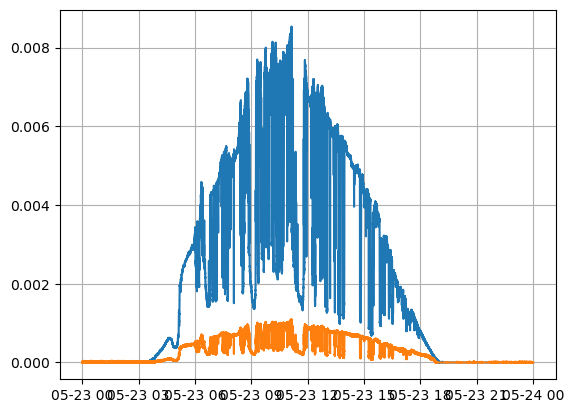

In [ ]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

### Drop first and last X minutes of data 
To avoid bad data due to maintenance during start or end of the maintenance interval, a certain amound of minutes is dropped (defined in config).

```{note}
config.json -> "stripminutes"
```

In [ ]:
#|dropcode
#|dropout
# 4. Drop first and last <stripminutes> minutes of data to avoid bad data due to maintenance

# stripminutes = np.timedelta64(int(config['stripminutes']), 'm')
# for now use some seconds for demonstration
stripminutes = np.timedelta64(2, 's')
tslice = slice(ds_l1b.time.values[0] + stripminutes,
               ds_l1b.time.values[-1] - stripminutes)
ds_l1b = ds_l1b.sel(time=tslice)
ds_l1b

<xarray.Dataset>
Dimensions:          (time: 5934694, station: 1, maintenancetime: 1)
Coordinates:
  * maintenancetime  (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
  * station          (station) float32 5.0
  * time             (time) datetime64[ns] 2024-05-21T16:24:06.650000 ... 202...
Data variables:
    ghi              (time, station) float32 ...
    gti              (time, station) float32 ...
    ta               (time, station) float32 ...
    rh               (time, station) float32 ...
    battery_voltage  (time, station) float32 ...
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:34.031000
    time_coverage_end:         2024-05-28T13:14:54
    time_coverage_duration:    P6DT20H50M19.969S
    time_coverage_resolution:  P0DT0H0M1.000001632S

###  Resample
Resample the data to desired time interval
    * ```pyrnet.data.resample```


In [ ]:
#|dropcode
#|dropout
# 6. resample to desired resolution
# save station coordinate
station_dim = {"station": ds_l1b["station"].values}
station_attrs = ds_l1b["station"].attrs

# resample on time dimension with specified methods
methods = ['mean'] + config["l1b_resample_stats"]
res = resample(
    ds_l1b.squeeze().drop_vars("station"), # drop station coordinate and variable
    freq=config['l1bfreq'],
    methods=methods,
    kwargs=dict(skipna=True)
)

# add standard names for new variables
ds_l1b = res[0]
for i, method in enumerate(methods[1:]):
    for var in config["radflux_varname"]:
        ds_l1b[f"{var}_{method}"] = res[i+1][var]
        ds_l1b[f"{var}_{method}"].attrs.update({
            "standard_name": f"{method}_"+ds_l1b[f"{var}_{method}"].attrs["standard_name"]
        })

# add station dimension back again
ds_l1b = ds_l1b.expand_dims(station_dim, axis=-1)
ds_l1b["station"].attrs.update(station_attrs)

# add maintenancetime coord
ds_l1b = ds_l1b.assign_coords({"maintenancetime":ds_l1a.maintenancetime})
ds_l1b

<xarray.Dataset>
Dimensions:          (station: 1, time: 593447, maintenancetime: 1)
Coordinates:
  * station          (station) float64 5.0
  * time             (time) datetime64[ns] 2024-05-21T16:24:06 ... 2024-05-28...
  * maintenancetime  (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
Data variables:
    ghi              (time, station) float32 0.0004086 0.0004086 ... 0.001032
    gti              (time, station) float32 4.301e-05 4.409e-05 ... 0.0001505
    ta               (time, station) float32 296.2 294.5 293.5 ... 286.7 286.6
    rh               (time, station) float32 0.8632 0.8321 ... 0.6726 0.6735
    battery_voltage  (time, station) float32 6.471 6.477 6.484 ... 5.159 5.161
    ghi_min          (time, station) float32 0.0004086 0.0004086 ... 0.001032
    gti_min          (time, station) float32 4.301e-05 4.301e-05 ... 0.0001505
    ghi_max          (time, station) float32 0.0004086 0.0004086 ... 0.001032
    gti_max          (time, station) float32 4.301e-05 5.376e-05 ... 0.0001505
    ghi_std          (time, station) float64 0.0 0.0 0.0 ... 1.039e-05 nan
    gti_std          (time, station) float64 0.0 3.4e-06 ... 4.534e-06 nan
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:34.031000
    time_coverage_end:         2024-05-28T13:14:54
    time_coverage_duration:    P6DT20H50M19.969S
    time_coverage_resolution:  P0DT0H0M1.000001632S

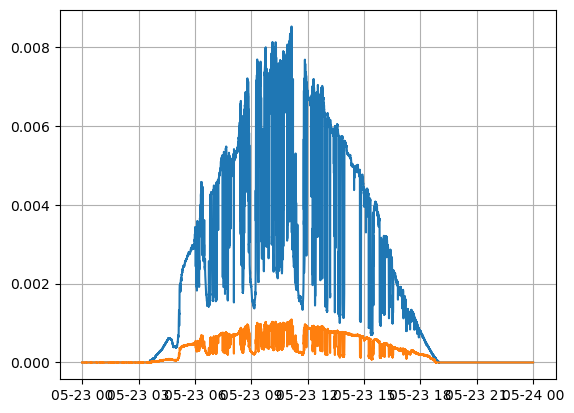

In [ ]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

### Interpolate GPS coordinates

Use ```xarray.interp``` to interpolate lat and lon to the resampled time dimension.
```{note}
At this point the descision to whether store geocoordinates in full time resolution or as mean over the time interval is made.

This is configured in config.json -> "average_latlon"
```

In [ ]:
#|dropcode
#|dropout

# 7. Interpolate GPS coordinates to bin time
ds_gps = ds_l1a.drop_dims("adctime")
ds_gps = ds_gps.drop_vars(['iadc'])


# Decide whether geo coordinates should be averaged or not

# if config['average_latlon']:
ds_gps_avg = ds_gps.mean('gpstime',skipna=True)
ds_l1b_avg = xr.merge((ds_l1b,ds_gps_avg))

# else:
ds_gps = ds_gps.interp(gpstime=ds_l1b.time,
                       kwargs={"bounds_error":False, "fill_value":np.nan})
ds_gps = ds_gps.drop_vars("gpstime")

ds_l1b = xr.merge((ds_l1b,ds_gps))

ds_l1b

<xarray.Dataset>
Dimensions:               (station: 1, time: 593447, maintenancetime: 1)
Coordinates:
  * station               (station) float64 5.0
  * time                  (time) datetime64[ns] 2024-05-21T16:24:06 ... 2024-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
Data variables: (12/15)
    ghi                   (time, station) float32 0.0004086 ... 0.001032
    gti                   (time, station) float32 4.301e-05 ... 0.0001505
    ta                    (time, station) float32 296.2 294.5 ... 286.7 286.6
    rh                    (time, station) float32 0.8632 0.8321 ... 0.6735
    battery_voltage       (time, station) float32 6.471 6.477 ... 5.159 5.161
    ghi_min               (time, station) float32 0.0004086 ... 0.001032
    ...                    ...
    ghi_std               (time, station) float64 0.0 0.0 0.0 ... 1.039e-05 nan
    gti_std               (time, station) float64 0.0 3.4e-06 ... 4.534e-06 nan
    lat                   (time, station) float64 nan nan nan ... 51.49 51.49
    lon                   (time, station) float64 nan nan nan ... 13.38 13.38
    maintenance_flag_ghi  (maintenancetime, station) float32 0.0
    maintenance_flag_gti  (maintenancetime, station) float32 4.0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:34.031000
    time_coverage_end:         2024-05-28T13:14:54
    time_coverage_duration:    P6DT20H50M19.969S
    time_coverage_resolution:  P0DT0H0M1.000001632S

In [ ]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

### Add sun position
Use ```trosat.sunpos``` to calculate sun position from time and lat,lon coordinates.


In [ ]:
#|dropcode
#|dropout
# 8. Calc and add sun position

szen, sazi = sp.sun_angles(
    time=ds_l1b.time.values[:,None],
    lat=ds_l1b.lat.values,
    lon=ds_l1b.lon.values
)


szen_avg, sazi_avg = sp.sun_angles(
    time=ds_l1b_avg.time.values[:,None],
    lat=ds_l1b_avg.lat.values,
    lon=ds_l1b_avg.lon.values
)

szen  = szen.squeeze()
sazi = sazi.squeeze()
szen_avg = szen_avg.squeeze()
sazi_avg = sazi_avg.squeeze()


esd = np.mean(sp.earth_sun_distance(ds_l1b.time.values))

print('szen (avg latlon):', szen_avg)
print('szen:', szen)
print('sazi  (avg latlon):', sazi_avg)
print('sazi:', sazi)
print('Earth-Sun Distance:',esd)

szen (avg latlon): [68.19801902 68.20059891 68.20317878 ... 39.20242716 39.20449024
 39.20655347]
szen: [        nan         nan         nan ... 39.20242553 39.20448861
 39.20655183]
sazi  (avg latlon): [275.71648725 275.71964551 275.72280373 ... 232.72731339 232.73250095
 232.73768813]
sazi: [         nan          nan          nan ... 232.72727391 232.73246147
 232.73764866]
Earth-Sun Distance: 1.0129257444929494


In [ ]:
#|dropcode
#|dropout
ds_l1b = ds_l1b.assign(
    {
        "szen": (("time", "station"), szen[:,None]),
        "sazi": (("time", "station"), sazi[:,None]),
        "esd": ("station", [esd])
    }
)
for key in ['szen', 'sazi','esd']:
    ds_l1b[key].attrs.update(vattrs[key])
    # ds_l1b[key].encoding.update(vencode[key])
ds_l1b

<xarray.Dataset>
Dimensions:               (station: 1, time: 593447, maintenancetime: 1)
Coordinates:
  * station               (station) float64 5.0
  * time                  (time) datetime64[ns] 2024-05-21T16:24:06 ... 2024-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
Data variables: (12/18)
    ghi                   (time, station) float32 0.0004086 ... 0.001032
    gti                   (time, station) float32 4.301e-05 ... 0.0001505
    ta                    (time, station) float32 296.2 294.5 ... 286.7 286.6
    rh                    (time, station) float32 0.8632 0.8321 ... 0.6735
    battery_voltage       (time, station) float32 6.471 6.477 ... 5.159 5.161
    ghi_min               (time, station) float32 0.0004086 ... 0.001032
    ...                    ...
    lon                   (time, station) float64 nan nan nan ... 13.38 13.38
    maintenance_flag_ghi  (maintenancetime, station) float32 0.0
    maintenance_flag_gti  (maintenancetime, station) float32 4.0
    szen                  (time, station) float64 nan nan nan ... 39.2 39.21
    sazi                  (time, station) float64 nan nan nan ... 232.7 232.7
    esd                   (station) float64 1.013
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:34.031000
    time_coverage_end:         2024-05-28T13:14:54
    time_coverage_duration:    P6DT20H50M19.969S
    time_coverage_resolution:  P0DT0H0M1.000001632S

### **(Not implemented)** Alignment detection
Detect the alignment of the instruments assuming perfect alignment at the beginning of the maintenance period. Refine GTI *hangle* and *vangle* if available. 

### Calibrate radiation flux

Calibration and correction of measured voltage (U) is done via the following equations:

$ \mathrm{GHI} = \mathrm{U} * \mathrm{C}_\mathrm{a} * \mathrm{C}_\mathrm{c}(\mu_a) * \frac{\mu_0}{\mu_a}$,

$ \mathrm{GTI} = \mathrm{U} * \mathrm{C}_\mathrm{a} * \mathrm{C}_\mathrm{c}(\mu_a)$,

with the absolute calibration factor $\mathrm{C}_\mathrm{a}$ $\left(\frac{W}{m^2}V^{-1}\right)$ and the cosine correction factor $\mathrm{C}_\mathrm{c}$ which depends on the cosine of the apparent solar zenith angle ($\mu_a$). The fraction $\frac{\mu_0}{\mu_a}$ is applied as a factor to correct for misalignment (neglecting diffuse radiation) ([Boers et al. (1998)](http://dx.doi.org/10.1029/98JD01431)).

Therefore, the full calibration including cosine and misalignment correction can only be applied if the apparent zenith angle is known. For GHI we apply the full calibration assuming $\mu_a = \mu_0$. For GTI, only the absolute calibration is added. GTI cosine correction is applied only if both *hangle* and *vangle* are known.  

In [65]:
# 5. rad flux calibration
box = ds_l1b.station.values[0]
boxnumber, serial, cfac, CCcoef = pyrnet.pyrnet.meta_lookup(
    ds_l1b.time.values[0],
    box=box,
    cfile=config['file_calibration'],
    mapfile=config['file_mapping'],
)

print(f"Meta Lookup:")
print(f">> Box = {box}")
print(f">> serial(s) = {serial}")
print(f">> calibration factor(s) = {cfac}")
print(f">> cosine correction factor = {np.polynomial.polynomial.Polynomial(CCcoef)},\n>>     with x = cos(apparent solar zenith angle)")

mu0 = np.cos(np.deg2rad(ds_l1b.szen.values))

# calibrate radiation flux with gain=300
for i, radflx in enumerate(config['radflux_varname']):
    # all radflux related variables (including <radflux>_<resamplemethod> variables)
    radflx_vars = [var for var in ds_l1b if var.startswith(radflx)]
    if cfac[i] is None:
        # drop if calibration/instrument don't exist (probably secondary pyranometer).
        ds_l1b = ds_l1b.drop_vars(radflx_vars)
        continue
    
    # calc apparent zenith angle if possible
    mua = mu0.copy()
    if "vangle" in ds[radflx].attrs:
        vangle = pyrnet.utils.make_iter(ds[radflx].attrs["vangle"])
        hangle = pyrnet.utils.make_iter(ds[radflx].attrs["hangle"])
        mua = pyrnet.utils.calc_apparent_coszen(
            pitch=vangle,
            yaw=hangle,
            zen=ds_l1b.szen.values,
            azi=ds_l1b.sazi.values
        )
    
    mask_mua = ~np.isnan(mua)
    Ca = 1e6/cfac[i]
    Cc = np.polynomial.polynomial.polyval(mua, c=CCcoef)
    Cmu = mu0/mua
    # apply to all variables
    for var in radflx_vars:
        calib_func = "flux (W m-2) = flux (V) * Cabsolute (W m-2 V-1)"
        C = np.ones(mu0.shape)*Ca
        if radflx == "gti":
            C[mask_mua] *= Cc[mask_mua]
            calib_func += "" if np.all(np.isnan(mua)) else " * Ccoscorr(mua)"
        else:
            C[mask_mua] *= Cc[mask_mua] * Cmu[mask_mua]
            calib_func += " * Ccoscorr(mua)"# * mu0/mua" (not implemented)
        ds_l1b[var].values = ds_l1b[var].values*C

        ds_l1b[var].attrs['units'] = "W m-2",
        ds_l1b[var].attrs.update({
            "units": "W m-2",
            "serial": serial[i],
            "calibration_Cabsolute": Ca,
            "calibration_Ccoscorr": str(np.polynomial.polynomial.Polynomial(CCcoef)),
            "calibration_function": calib_func
        })
ds_l1b

Meta Lookup:
>> Box = 5.0
>> serial(s) = ['S12128.005', 'S12137.047']
>> calibration factor(s) = [7.57, 6.27]
>> cosine correction factor = 1.39 - 2.52·x¹ + 4.37·x² - 2.23·x³,
>>     with x = cos(apparent solar zenith angle)


In [64]:
dsp = ds_l1b.sel(time="2024-05-23")
plt.figure()
plt.plot(dsp.time, dsp.ghi)
plt.plot(dsp.time, dsp.gti)
plt.grid()

0.1330222215594891 82.35572994370557 1.1268617539775345


### Add automatic quality flags
Add BSRN recommended limit checks and intercompare checks if multiple pyranometers are in the dataset.

In [ ]:
#|dropcode
#|dropout
ds_l1b = pyrnet.qcrad.add_qc_flags(ds_l1b, config["radflux_varname"])
ds_l1b

<xarray.Dataset>
Dimensions:               (station: 1, time: 593447, maintenancetime: 1)
Coordinates:
  * station               (station) float64 5.0
  * time                  (time) datetime64[ns] 2024-05-21T16:24:06 ... 2024-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
Data variables: (12/20)
    ghi                   (time, station) float64 53.98 53.98 ... 140.5 139.6
    gti                   (time, station) float64 6.86 7.031 ... 24.23 24.58
    ta                    (time, station) float32 296.2 294.5 ... 286.7 286.6
    rh                    (time, station) float32 0.8632 0.8321 ... 0.6735
    battery_voltage       (time, station) float32 6.471 6.477 ... 5.159 5.161
    ghi_min               (time, station) float64 53.98 53.98 ... 139.6 139.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 4.0
    szen                  (time, station) float64 nan nan nan ... 39.2 39.21
    sazi                  (time, station) float64 nan nan nan ... 232.7 232.7
    esd                   (station) float64 1.013
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 64 64 64 64 64 ... 21 21 21 21
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:34.031000
    time_coverage_end:         2024-05-28T13:14:54
    time_coverage_duration:    P6DT20H50M19.969S
    time_coverage_resolution:  P0DT0H0M1.000001632S

### Update variables and global attributes and encoding

In [ ]:
#|dropcode
#|dropout
# add global coverage attributes
ds_l1b = update_coverage_meta(ds_l1b, timevar="time")

ds_l1b.attrs["processing_level"] = 'l1b'
now = pd.to_datetime(np.datetime64("now"))
ds_l1b.attrs["history"] = ds_l1b.history + f"{now.isoformat()}: Generated level l1b  by pyrnet version {pyrnet_version}; "

ds_l1b

<xarray.Dataset>
Dimensions:               (station: 1, time: 593447, maintenancetime: 1)
Coordinates:
  * station               (station) float64 5.0
  * time                  (time) datetime64[ns] 2024-05-21T16:24:06 ... 2024-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
Data variables: (12/20)
    ghi                   (time, station) float64 53.98 53.98 ... 140.5 139.6
    gti                   (time, station) float64 6.86 7.031 ... 24.23 24.58
    ta                    (time, station) float32 296.2 294.5 ... 286.7 286.6
    rh                    (time, station) float32 0.8632 0.8321 ... 0.6735
    battery_voltage       (time, station) float32 6.471 6.477 ... 5.159 5.161
    ghi_min               (time, station) float64 53.98 53.98 ... 139.6 139.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 4.0
    szen                  (time, station) float64 nan nan nan ... 39.2 39.21
    sazi                  (time, station) float64 nan nan nan ... 232.7 232.7
    esd                   (station) float64 1.013
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 64 64 64 64 64 ... 21 21 21 21
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:06
    time_coverage_end:         2024-05-28T13:14:52
    time_coverage_duration:    P6DT20H50M46S
    time_coverage_resolution:  P0DT0H0M1S

In [ ]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

<xarray.Dataset>
Dimensions:               (station: 1, time: 593447, maintenancetime: 1)
Coordinates:
  * station               (station) float64 5.0
  * time                  (time) datetime64[ns] 2024-05-21T16:24:06 ... 2024-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2024-05-28T15:18:50
Data variables: (12/20)
    ghi                   (time, station) float64 53.98 53.98 ... 140.5 139.6
    gti                   (time, station) float64 6.86 7.031 ... 24.23 24.58
    ta                    (time, station) float32 296.2 294.5 ... 286.7 286.6
    rh                    (time, station) float32 0.8632 0.8321 ... 0.6735
    battery_voltage       (time, station) float32 6.471 6.477 ... 5.159 5.161
    ghi_min               (time, station) float64 53.98 53.98 ... 139.6 139.6
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 4.0
    szen                  (time, station) float64 nan nan nan ... 39.2 39.21
    sazi                  (time, station) float64 nan nan nan ... 232.7 232.7
    esd                   (station) float64 1.013
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 64 64 64 64 64 ... 21 21 21 21
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T09:42:18: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        13.380511666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2024-05-21T16:24:06
    time_coverage_end:         2024-05-28T13:14:52
    time_coverage_duration:    P6DT20H50M46S
    time_coverage_resolution:  P0DT0H0M1S

In [ ]:
#|hide
# ds_l1b.to_netcdf("../../testnb/to_l1b_output.nc",
#                  encoding={'time':{'dtype':'float64'}})

In [ ]:
#|hide
# dsp = xr.load_dataset("../../testnb/to_l1b_output.nc").sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

## to_l1b function

In [ ]:
#|export
#|dropcode
def to_l1b(
        fname: str,
        *,
        config: dict | None = None,
        global_attrs: dict | None = None,
        check_adc_sync: bool = True
) -> xr.Dataset|None:

    config = get_config(config)
    gattrs, vattrs, vencode = get_cfmeta(config)

    if global_attrs is not None:
        gattrs.update(global_attrs)

    ######################################################################################
    ## Load l1a data
    ds_l1a = xr.open_dataset(fname)
    # check correct file
    if ds_l1a.processing_level != "l1a":
        logger.warning(f"{fname} is not a l1a file. Skip.")
        return None

    ######################################################################################
    ## Sync GPS to ADC time
    adctime = pyrnet.logger.sync_adc_time(
        adctime = ds_l1a.adctime.values,
        gpstime = ds_l1a.gpstime.values,
        iadc = ds_l1a.iadc.squeeze().values.astype(int),
        check_results = check_adc_sync
    )
    
    if adctime is None:
        logger.warning(f"Could not fit GPS to ADC time for file {fname}. Skip.")
        return None

    ######################################################################################
    ## Create new dataset (l1b)
    ds_l1b = ds_l1a.drop_dims('gpstime')
    ds_l1b = ds_l1b.drop_vars(['maintenance_flag_ghi','maintenance_flag_gti']) # keep only time dependent variables
    ds_l1b = ds_l1b.assign({'time': ('adctime', adctime)})
    ds_l1b = ds_l1b.swap_dims({"adctime":"time"})
    ds_l1b = ds_l1b.drop_vars("adctime")

    ds_l1b["time"].encoding.update({
        "dtype": 'float64',
        "units": f"seconds since {np.datetime_as_string(ds_l1b.time.data[0], unit='D')}T00:00Z",
    })
    logger.info(f"Dataset time coverage before strip: {ds_l1b.time.values[0]} - {ds_l1b.time.values[-1]}")

    ######################################################################################
    ## Drop first and last <stripminutes> minutes of data to avoid bad data due to maintenance
    stripminutes = np.timedelta64(int(config['stripminutes']), 'm')
    if (ds_l1b.time.values[0] + 3*stripminutes) > ds_l1b.time.values[-1]:
        logger.warning(f"{fname} has not enough data. Skip.")
        return None

    ds_l1b = ds_l1b.isel(time=ds_l1b.time>ds_l1b.time.values[0] + stripminutes)
    ds_l1b = ds_l1b.isel(time=ds_l1b.time<ds_l1b.time.values[-1] - stripminutes)
    if ds_l1b.time.size < 10:
        logger.warning(f"{fname} has not enough data, after strip. Skip.")
        return None


    logger.info(f"Dataset time coverage after strip: {ds_l1b.time.values[0]} - {ds_l1b.time.values[-1]}")

    #####################################################################################
    ## resample to desired resolution
    # save station coordinate
    station_dim = {"station": ds_l1b["station"].values}
    station_attrs = ds_l1b["station"].attrs

    # resample on time dimension with specified methods
    methods = ['mean'] + config["l1b_resample_stats"]
    res = resample(
        ds_l1b.squeeze().drop_vars("station"), # drop station coordinate and variable
        freq=config['l1bfreq'],
        methods=methods,
        kwargs=dict(skipna=True)
    )
    
    # add standard names for new variables
    # apply for variables if both in config['radflux_varname'] and ds_l1b.keys()
    radflux_vars = list(set(config['radflux_varname'])&set(ds_l1b.keys()))
    ds_l1b = res[0]
    for i, method in enumerate(methods[1:]):
        for var in radflux_vars:
            ds_l1b[f"{var}_{method}"] = res[i+1][var]
            ds_l1b[f"{var}_{method}"].attrs.update({
                "standard_name": f"{method}_"+ds_l1b[f"{var}_{method}"].attrs["standard_name"]
            })
    
    # add station dimension back again
    ds_l1b = ds_l1b.expand_dims(station_dim, axis=-1)
    ds_l1b["station"].attrs.update(station_attrs)
    
    # add maintenancetime coord
    ds_l1b = ds_l1b.assign_coords({"maintenancetime":ds_l1a.maintenancetime})
    
    ######################################################################################
    ## Interpolate GPS coordinates to l1b time
    ds_gps = ds_l1a.drop_dims("adctime")
    ds_gps = ds_gps.drop_vars(['iadc'])

    # Decide whether geo coordinates should be averaged or not
    if config['average_latlon']:
        ds_gps = ds_gps.mean('gpstime', skipna=True, keep_attrs=True)
    else:
        ds_gps = ds_gps.interp(gpstime=ds_l1b.time)
        ds_gps = ds_gps.drop_vars("gpstime")

    ds_l1b = xr.merge((ds_l1b,ds_gps))

    ######################################################################################
    ## Calc and add sun position
    szen, sazi = sp.sun_angles(
        time=ds_l1b.time.values[:,None], # line up with coordinates to keep dependence on time only
        lat=ds_l1b.lat.values,
        lon=ds_l1b.lon.values
    )
    szen  = szen.squeeze()
    sazi = sazi.squeeze()

    esd = np.mean(sp.earth_sun_distance(ds_l1b.time.values))

    ds_l1b = ds_l1b.assign(
        {
            "szen": (("time", "station"), szen[:,None]),
            "sazi": (("time", "station"), sazi[:,None]),
            "esd": ("station", [esd])
        }
    )
    # update attributes and encoding
    for key in ['szen', 'sazi','esd']:
        ds_l1b[key].attrs.update(vattrs[key])

    ######################################################################################
    ## rad flux calibration
    box = ds_l1b.station.values[0]
    boxnumber, serial, cfac, CCcoef = pyrnet.pyrnet.meta_lookup(
        ds_l1b.time.values[0],
        box=box,
        cfile=config['file_calibration'],
        mapfile=config['file_mapping'],
    )
    logger.info(f"Meta Lookup:")
    logger.info(f">> Box={box}")
    logger.info(f">> serial(s)={serial}")
    logger.info(f">> calibration factor(s)={cfac}")

    mu0 = np.cos(np.deg2rad(ds_l1b.szen.values))
    
    # calibrate radiation flux with gain=300
    for i, radflx in enumerate(config['radflux_varname']):
        # all radflux related variables (including <radflux>_<resamplemethod> variables)
        radflx_vars = [var for var in ds_l1b if var.startswith(radflx)]
        if cfac[i] is None:
            # drop if calibration/instrument don't exist (probably secondary pyranometer).
            ds_l1b = ds_l1b.drop_vars(radflx_vars)
            continue
        
        # calc apparent zenith angle if possible
        mua = mu0.copy()
        if "vangle" in ds_l1b[radflx].attrs:
            vangle = pyrnet.utils.make_iter(ds_l1b[radflx].attrs["vangle"])
            hangle = pyrnet.utils.make_iter(ds_l1b[radflx].attrs["hangle"])
            mua = pyrnet.utils.calc_apparent_coszen(
                pitch=vangle,
                yaw=hangle,
                zen=ds_l1b.szen.values,
                azi=ds_l1b.sazi.values
            )
        
        mask_mua = ~np.isnan(mua)
        Ca = 1e6/cfac[i]
        Cc = np.polynomial.polynomial.polyval(mua, c=CCcoef)
        Cmu = mu0/mua
        # apply to all variables
        for var in radflx_vars:
            calib_func = "flux (W m-2) = flux (V) * Cabsolute (W m-2 V-1)"
            C = np.ones(mu0.shape)*Ca
            if radflx == "gti":
                C[mask_mua] *= Cc[mask_mua]
                calib_func += "" if np.all(np.isnan(mua)) else " * Ccoscorr(mua)"
            else:
                C[mask_mua] *= Cc[mask_mua] * Cmu[mask_mua]
                calib_func += " * Ccoscorr(mua)" # * mu0/mua" (not implemented)
            ds_l1b[var].values = ds_l1b[var].values*C
    
            ds_l1b[var].attrs['units'] = "W m-2",
            ds_l1b[var].attrs.update({
                "units": "W m-2",
                "serial": serial[i],
                "calibration_Cabsolute": Ca,
                "calibration_Ccoscorr": str(np.polynomial.polynomial.Polynomial(CCcoef)),
                "calibration_function": calib_func
            })

    ######################################################################################  
    ## add quality flags
    ds_l1b = pyrnet.qcrad.add_qc_flags(ds_l1b, config["radflux_varname"])

    ######################################################################################
    ## Update variables, global attributes and encoding
    #add global coverage attributes
    ds_l1b = update_coverage_meta(ds_l1b, timevar="time")
    ds_l1b.attrs["processing_level"] = 'l1b'
    ds_l1b.attrs["product_version"] = pyrnet_version
    now = pd.to_datetime(np.datetime64("now"))
    ds_l1b.attrs["history"] = ds_l1b.history + f"{now.isoformat()}: Generated level l1b  by pyrnet version {pyrnet_version}; "

    # update encoding
    ds_l1b = add_encoding(ds_l1b, vencode=vencode)

    return ds_l1b

## Test to_l1b function

In [ ]:
#|dropcode
#|dropout
fname = "../../example_data/to_l1a_output.nc"
config = {
    "l1bfreq":"1s",
    "campaign": "test",
    "stripminutes":0,
    "average_latlon":True,
    "l1b_resample_stats": ["min", "max", "std"],
    "radflux_varname": ["ghi","gti"]
}

ds_l1b = to_l1b(fname=fname, config=config, check_adc_sync=False)

print("Processing fname:")
print(get_fname(ds_l1b, freq='1s', timevar="time", config=config))

ds_l1b.to_netcdf("../../example_data/to_l1b_output.nc")
ds_l1b

Processing fname:
2022-08-30_P0DT0H0M8S_pyrnet_test_s001l1bf1s.c01.nc


<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float64 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float64 289.0 289.0 ... 288.6 289.4
    ta                    (time, station) float32 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float32 0.6253 0.6248 ... 0.628 0.629
    battery_voltage       (time, station) float32 6.443 6.445 ... 6.449 6.465
    ghi_min               (time, station) float64 280.9 280.9 ... 280.9 280.9
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 7.0
    szen                  (time, station) float64 42.51 42.51 ... 42.51 42.51
    sazi                  (time, station) float64 182.9 182.9 ... 182.9 182.9
    esd                   (station) float64 1.01
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 0 0 0 0 0 0 0 0 0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-03-19T13:35:34: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885252
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S

In [ ]:
import cfchecker.cfchecks
init = cfchecker.cfchecks.CFChecker()
res = init.checker("../../example_data/to_l1b_output.nc")

Processing fname:
2022-08-30_P0DT0H0M8S_pyrnet_test_s001l1bf1s.c01.nc


<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float64 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float64 289.0 289.0 ... 288.6 289.4
    ta                    (time, station) float32 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float32 0.6253 0.6248 ... 0.628 0.629
    battery_voltage       (time, station) float32 6.443 6.445 ... 6.449 6.465
    ghi_min               (time, station) float64 280.9 280.9 ... 280.9 280.9
    ...                    ...
    maintenance_flag_gti  (maintenancetime, station) float32 7.0
    szen                  (time, station) float64 42.51 42.51 ... 42.51 42.51
    sazi                  (time, station) float64 182.9 182.9 ... 182.9 182.9
    esd                   (station) float64 1.01
    qc_flag_ghi           (time, station) uint8 0 0 0 0 0 0 0 0 0
    qc_flag_gti           (time, station) uint8 0 0 0 0 0 0 0 0 0
Attributes: (12/31)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T12:29:32: Generated level l1a  by p...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_max:        11.885252
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S

In [ ]:
#|dropout
import netCDF4
netCDF4.Dataset("../../example_data/to_l1b_output.nc",'r')

CHECKING NetCDF FILE: ../../example_data/to_l1b_output.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 85 (2024-05-21T15:55:10Z)
Using Area Type Table Version 11 (06 July 2023)
Using Standardized Region Name Table Version 4 (18 December 2018)

ERROR: (2.6.1): This netCDF file does not appear to contain CF Convention data.

------------------
Checking variable: station
------------------
WARN: (3): No standard_name or long_name attribute specified
WARN: (3.1): units attribute should be present

------------------
Checking variable: time
------------------
WARN: (3): No standard_name or long_name attribute specified

------------------
Checking variable: ghi
------------------
ERROR: (8.1): must be of type byte, short or int

------------------
Checking variable: gti
------------------
ERROR: (8.1): must be of type byte, short or int

------------------
Checking variable: ta
------------------
ERROR: (8.1): must be of type byte, shor

## Merging
Merging datasets with xarray default merge overwrites or drops certain variable attributes (e.g., serial number, calibration factor). The methods here are specialized to merge PyrNet datasets and attributes.   

In [ ]:
# make 3 artificial datasets for testing
# original ds_l1b
ds1 = ds_l1b.copy()
ds1.attrs["site"] = "testsite1"
# ds_l1b but new times
ds2 = ds1.copy()
ds2 = ds2.assign_coords({
    "time": ("time", ds2.time.values+(ds2.time.values[-1]-ds2.time.values[0]))
})
# ds_l1b, same time but other station
ds3 = ds1.copy()
ds3 = ds3.assign_coords({
    "station": ("station", [2])
})
ds3.attrs["site"] = "testsite2"
for var in ds3:
    if "ghi" in var:
        ds3[var].attrs["serial"] = "test_ghi_ds3"
    if "gti" in var:
        ds3[var].attrs["serial"] = "test_gti_ds3"

dslist = [ds1, ds3, ds2]


### Sort by station coordinates
Before merging, sort them by station

In [ ]:
#|export
#|dropcode
def _sort_by_station(dslist):
    # sort dslist for first station
    station0 = []
    for i in range(len(dslist)):
        station0.append(int(dslist[i]["station"].values[0]))
    isort = np.argsort(station0).ravel()
    dslist = [dslist[i] for i in isort]
    return dslist


In [ ]:
#|dropout
dslist = _sort_by_station(dslist)
[print(dslist[i].station.values) for i in range(len(dslist))]

### Merge global and variable attributes
Some attributes are tied to a specific statin (e.g., calibration factor, serial number). These attributes are converted to a list and merged with respect to the station dimension.

In [ ]:
#|export
#|dropcode
def _merge_gattrs_by_station(dslist, merge_gattrs):
    # merge variable attrs:
    merge_gattrs_fill_value = [merge_gattrs[key] for key in merge_gattrs] 
    merge_gattrs = [key for key in merge_gattrs]
    
    merged_gattrs = {}
    gattrs_idx = {}
    for i in range(len(dslist)):
        dst = dslist[i]
        for j,attr in enumerate(merge_gattrs):
            if attr not in dst.attrs:
                fill_value = dst.station.size * [merge_gattrs_fill_value[j]]
                dst.attrs.update({
                    attr: fill_value
                })
            # save station index, as attributes are related to station dimension
            attridx = list(dst.station.values.astype(int))
            attrval = list(pyrnet.utils.make_iter(dst.attrs[attr]))
            # merge attributes, overwrite values of same station
            if attr in merged_gattrs:
                mattrval = merged_gattrs[attr] + attrval
                mattridx = gattrs_idx[attr] + attridx
                _,idx = np.unique(mattridx, return_index=True)
                attridx = [mattridx[i] for i in idx]
                attrval = [mattrval[i] for i in idx]
            gattrs_idx = assoc_in(
                gattrs_idx, [attr], attridx
            )
            merged_gattrs = assoc_in(
                merged_gattrs, [attr], attrval
            )
    return merged_gattrs

def _merge_vattrs_by_station(dslist, merge_attrs):
    # add missing gti variables
    for i in range(len(dslist)):
        dst = dslist[i].copy()
        if "gti" in dst:
            continue
        ghi_vars = [var for var in dst if "ghi" in var]
        gti_vars = [var.replace("ghi","gti") for var in ghi_vars]
        for ghi_var, gti_var in zip(ghi_vars,gti_vars):
            dst = dst.assign({
                gti_var: (dst[ghi_var].dims, np.full(dst[ghi_var].shape, np.nan))
            })
            for attr in merge_attrs:
                skip = True
                for apply_to in merge_attrs[attr]["apply_to"]:
                    if gti_var.startswith(apply_to):
                        skip = False
                if skip:
                    continue
                fill_value = dst.station.size * [merge_attrs[attr]["fill_value"]]
                dst[gti_var].attrs.update({
                    attr: fill_value
                })
        dslist[i] = dst
    
    merged_attrs = {}
    mattrs_idx = {}
    for i in range(len(dslist)):
        dst = dslist[i]
        for var in dst:
            for attr in merge_attrs:
                skip = True
                for apply_to in merge_attrs[attr]["apply_to"]:
                    if var.startswith(apply_to):
                        skip = False
                if skip:
                    continue
                if attr not in dst[var].attrs:
                    fill_value = dst.station.size * [merge_attrs[attr]["fill_value"]]
                    dst[var].attrs.update({
                        attr: fill_value
                     })
                # save station index, as attributes are related to station dimension
                attridx = list(dst.station.values.astype(int))
                attrval = list(pyrnet.utils.make_iter(dst[var].attrs[attr]))

                # merge attributes, overwrite values of same station
                if var not in merged_attrs:
                    merged_attrs.update({var:{}})
                    mattrs_idx.update({var:{}})
                if attr in merged_attrs[var]:
                    mattrval = merged_attrs[var][attr] + attrval
                    mattridx = mattrs_idx[var][attr] + attridx
                    
                    _,idx = np.unique(mattridx, return_index=True)
                    attridx = [mattridx[i] for i in idx]
                    attrval = [mattrval[i] for i in idx]
                mattrs_idx = assoc_in(
                    mattrs_idx, [var,attr], attridx
                )
                merged_attrs = assoc_in(
                    merged_attrs, [var,attr], attrval
                )
    return dslist, merged_attrs
    

In [ ]:
#|dropout
merged_gattrs = _merge_gattrs_by_station(dslist, merge_gattrs={"site":""})
print(merged_gattrs)
_, merged_attrs = _merge_vattrs_by_station(
    dslist,
    merge_attrs={
        "serial":dict(
            apply_to=["ghi","gti"],
            fill_value=""
        ),
        "note_general":dict(
            apply_to=["maintenance"],
            fill_value=""
        ),})
print(merged_attrs)

### Dataset unification
Reindex all kinds of dimension to unify datasets.

In [ ]:
#|export
#|dropcode
def _reindex_time(dslist, freq='1s', timevar='time'):
    dates = []
    for i in range(len(dslist)):
        # reindex to full day
        dates.append(dslist[i][timevar].values[0].astype("datetime64[D]"))
    udates = np.unique(dates)
    
    timeidx = pd.DatetimeIndex([])
    for date in udates:
        timeidx = timeidx.append(pd.date_range(
            date,
            date + np.timedelta64(1, 'D'),
            freq=freq,
            inclusive='left'
        ))
    
    for i in range(len(dslist)):
        dslist[i] = dslist[i].reindex(
            {timevar:timeidx},
            method='nearest',
            tolerance=np.timedelta64(1, 'ms')
        )
    return dslist

def _reindex_station(dslist):
    stations = []
    for i in range(len(dslist)):
        # reindex to full day
        stations += list(dslist[i].station.values)
    ustations = np.unique(stations)
    for i in range(len(dslist)):
        dslist[i] = dslist[i].reindex(
            {"station":ustations},
            method='nearest',
            tolerance=1e-6
        )
    return dslist

def _reindex_maintenancetime(dslist):
    mtimes = []
    for i in range(len(dslist)):
        # reindex to full day
        mtimes += list(dslist[i].maintenancetime.values)
    umtimes = np.unique(mtimes)
    for i in range(len(dslist)):
        dslist[i] = dslist[i].reindex(
            {"maintenancetime":umtimes},
            method='nearest',
            tolerance=np.timedelta64(1, 'ms')
        )
    return dslist

### Snap Maintenance time coordinate
The Maintenancetime coordinate is given at report time, which is actually somewhere after the maintenance. Assuming the report takes place on same or next day, we snap the coordinate to matching data gaps of 10-120min. 

In [ ]:
#|export
#|dropcode
def _maintenancetime_snap_to_gap(ds):
    old_mtimes = ds.maintenancetime.values
    new_mtimes = old_mtimes.copy()
    for i, mtime in enumerate(old_mtimes):
        dtime = mtime.astype("datetime64[D]") - ds.time.values[0].astype("datetime64[D]")
        # consider only same or next day maintenance times for snapping
        if (dtime > np.timedelta64(1,"D") or
            dtime < np.timedelta64(0,"D")):
            continue
        # lookup station
        istation = np.argwhere(~np.isnan(
            ds.maintenance_flag_ghi.values[i,:]
        ))[0][0]
        # identify gaps and gap length
        igap = np.argwhere(np.isnan(
            ds.ghi.isel(station=istation).values
        )).ravel()
        if len(igap)<10:
            continue
        digap = np.diff(igap)
        istartgaps = np.insert(digap,0,0)!=1
        iendgaps = np.insert(digap,-1,0)!=1
        # checkout only gaps of certain length
        gaptimes = []
        gapidxs = []
        for istart,iend in zip(igap[istartgaps],igap[iendgaps]):
            gaptime = ds.time.values[iend] - ds.time.values[istart]
            # assume maintenance takes at least 10 min and maximum 2h
            if (np.timedelta64(10, "m") < gaptime < np.timedelta64(2, 'h')):
                gapidxs.append(istart)
                gaptimes.append(ds.time.values[istart])
        if len(gaptimes)==0:
            continue
        # snap maintenance time to the closest matching gap
        new_mtimes[i] = gaptimes[np.argmin([mtime-gtime for gtime in gaptimes])]
    # update maintenancetime coordinate
    ds = ds.assign_coords({
        "maintenancetime": ("maintenancetime", new_mtimes)
    })
    ds = ds.sortby("maintenancetime")
    
    # merge duplicates
    dates, counts = np.unique(ds.maintenancetime.values,return_counts=True)
    duplets = dates[counts>1]
    if len(duplets)>0:
        dsold = ds.copy()
        ds = ds.drop_duplicates(dim='maintenancetime', keep='first')
        for ddate in duplets:
            dst = dsold.sel(maintenancetime=ddate)
            vars = [var for var in dst if "maintenancetime" in  dst[var].dims]
            for var in vars:
                for i in range(dst.maintenancetime.size-1):
                    mask = np.isnan(ds[var].sel(maintenancetime=ddate).values)
                    ds[var].sel(maintenancetime=ddate).values[mask] = dst[var].isel(maintenancetime=i+1).values[mask]
    
    return ds

### Merging processed datasets

In [ ]:
#|export
#|dropcode
def merge_l1b(
        dslist,
        freq='1s',
        timevar='time',
        merge_gattrs={"site":""},
        merge_attrs={
            "calibration_Cabsolute":dict(
                fill_value=0,
                apply_to=["ghi", "gti"]
            ),
            "serial":dict(
                fill_value="",
                apply_to=["ghi", "gti"]
            ),
            "vangle":dict(
                fill_value=0,
                apply_to=["ghi", "gti"]
            ),
            "hangle":dict(
                fill_value=0,
                apply_to=["ghi", "gti"]
            ),
            "note_general":dict(
                fill_value="",
                apply_to=["maintenance"]
            ),
            "note_clean":dict(
                fill_value="",
                apply_to=["maintenance"]
            ),
            "note_level":dict(
                fill_value="",
                apply_to=["maintenance"]
            ),
        }
):
    # sort by first station coordinate
    dslist = _sort_by_station(dslist)
    
    ################################################################
    ## Merge Attributes
    # have to merge attributes before reindexing, 
    # as attributes are tied the specific stations in the current datasets
    merged_gattrs = _merge_gattrs_by_station(dslist, merge_gattrs=merge_gattrs)
    dslist, merged_attrs = _merge_vattrs_by_station(dslist, merge_attrs=merge_attrs)
    
    #####################################################################
    ## Unify datasets
    # reindex timevar:
    dslist = _reindex_time(dslist, freq=freq, timevar=timevar)
    # reindex station var:
    dslist = _reindex_station(dslist)
    # reindex maintenancetime var:
    dslist = _reindex_maintenancetime(dslist)
    
    #####################################################################
    ## Merge datasets
    # merge vars with (time,station) dims
    for i in range(len(dslist)):
        dst = dslist[i].copy()
        dst = dst.drop_vars(
            [var for var in dst if not (timevar in dst[var].dims and "station" in dst[var].dims)]
        )
        if i==0:
            ds_time_station = dst.copy()
        else:
            # handle overlapping values by dropping from the first (override from second)
            for var in dst:
                overlap = (~np.isnan(dst[var].values))*(~np.isnan(dst[var].values))
                ds_time_station[var].values = ds_time_station[var].values.astype(float)
                ds_time_station[var].values[overlap] = np.nan
            ds_time_station = ds_time_station.merge(dst)
            
    # merge vars with (maintenancetime, station) dims
    for i in range(len(dslist)):
        dst = dslist[i].copy()
        dst = dst.drop_vars(
            [var for var in dst if not ("maintenancetime" in dst[var].dims and "station" in dst[var].dims)]
        )
        if i==0:
            ds_mtime_station = dst.copy()
        else:
            for var in dst:
                overlap = (~np.isnan(dst[var].values))*(~np.isnan(dst[var].values))
                ds_mtime_station[var].values = ds_mtime_station[var].values.astype(float)
                ds_mtime_station[var].values[overlap] = np.nan
            ds_mtime_station = ds_mtime_station.merge(dst)
    
    # merge vars with (station) dims
    for i in range(len(dslist)):
        dst = dslist[i].copy()
        dst = dst.drop_vars(
            [var for var in dst if not (len(dst[var].dims)==1 and "station" in dst[var].dims)]
        )
        if i==0:
            ds_station = dst.copy()
        else:
            try:
                # works there is no overlap with non null values ( new stations )
                ds_station = ds_station.merge(dst, compat='no_conflicts')
            except:
                # override if station already exists
                # but fill nan values if available in second dataset
                ustations = np.unique(list(ds_station.station.values)+list(dst.station.values))
                ds_station = ds_station.reindex(station=ustations)
                dst = dst.reindex(station=ustations)
                for key in list(set(ds_station.keys())&set(dst.keys())):
                    mask = np.isnan(ds_station[key].values)
                    ds_station[key].values[mask] = dst[key].values[mask]
                ds_station = ds_station.merge(dst, compat='override')
    
    ds_merged = xr.merge([ds_time_station,ds_station,ds_mtime_station])
    
    ###########################################################################
    ## add merged attrs
    # write new history
    now = pd.to_datetime(np.datetime64("now"))
    ds_merged.attrs["history"] = f"{now.isoformat()}: Merged level l1b by pyrnet version {pyrnet_version}; "
    
    # save merged global attrs
    for attr in ds_merged.attrs:
        if attr not in merge_gattrs:
            continue
        ds_merged.attrs[attr] = merged_gattrs[attr]
    
    # save merged variable attrs
    for var in ds_merged:
        for attr in ds_merged[var].attrs:
            if attr not in merge_attrs:
                continue
            ds_merged[var].attrs[attr] = merged_attrs[var][attr]
  
    #############################################################################
    ## maintenance time snap to data gap
    # check maintenance time per station
    # if its in time range, scan for gaps >10min and snap closest maintenance time to this gaps
    ds_merged = _maintenancetime_snap_to_gap(ds_merged)
    
    # update automatic quality flags
    ds_merged = pyrnet.qcrad.add_qc_flags(ds_merged, ["ghi","gti"])
    # add encoding
    ds_merged = add_encoding(ds_merged)
    return ds_merged


### Test merging

In [ ]:
#|dropout
#|dropcode
ds_merged = merge_l1b(dslist,freq='1s',timevar='time')
ds_merged.reindex_like(dslist[0])

<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float64 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float64 289.0 289.0 ... 288.6 289.0
    ta                    (time, station) float64 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float64 0.6253 0.6248 ... 0.628 0.6253
    battery_voltage       (time, station) float64 6.443 6.445 ... 6.449 6.443
    ghi_min               (time, station) float64 280.9 280.9 ... 280.9 280.9
    ...                    ...
    qc_flag_gti           (time, station) uint8 0 0 0 0 0 0 0 0 0
    lat                   (station) float64 51.39
    lon                   (station) float64 11.89
    esd                   (station) float64 1.01
    maintenance_flag_ghi  (maintenancetime, station) float64 9.0
    maintenance_flag_gti  (maintenancetime, station) float64 7.0
Attributes: (12/32)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-03-19T13:35:40: Merged level l1b by pyrne...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S
    site:                      ['testsite1', 'testsite2']

In [ ]:
#|hide
# #|export
# def merge_ds(ds1, ds2, timevar="time"):
#     """Merge two datasets along the time dimension.
#     """
#     if ds1[timevar].equals(ds2[timevar]):
#         logging.info("Overwrite existing file.")
#         return ds2
#     logging.info("Merge with existing file.")
# 
#     ## overwrite non time dependent variables
#     overwrite_vars = [ v for v in ds1 if timevar not in ds1[v].dims ]
# 
#     ## merge both datasets
#     ds_new=ds1.merge(ds2,
#                      compat='no_conflicts',
#                      overwrite_vars=overwrite_vars)
# 
#     # add global coverage attributes
#     ds_new.attrs.update({'merged':1})
# 
#     # add encoding again
#     ds_new = add_encoding(ds_new)
#     return ds_new

<xarray.Dataset>
Dimensions:               (station: 1, time: 9, maintenancetime: 1)
Coordinates:
  * station               (station) float64 1.0
  * time                  (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-...
  * maintenancetime       (maintenancetime) datetime64[ns] 2023-05-08T16:09:06
Data variables: (12/20)
    ghi                   (time, station) float64 280.9 280.9 ... 280.9 280.9
    gti                   (time, station) float64 289.0 289.0 ... 288.6 289.0
    ta                    (time, station) float64 294.8 294.7 ... 294.7 294.8
    rh                    (time, station) float64 0.6253 0.6248 ... 0.628 0.6253
    battery_voltage       (time, station) float64 6.443 6.445 ... 6.449 6.443
    ghi_min               (time, station) float64 280.9 280.9 ... 280.9 280.9
    ...                    ...
    qc_flag_gti           (time, station) uint8 0 0 0 0 0 0 0 0 0
    lat                   (station) float64 51.39
    lon                   (station) float64 11.89
    esd                   (station) float64 1.01
    maintenance_flag_ghi  (maintenancetime, station) float64 9.0
    maintenance_flag_gti  (maintenancetime, station) float64 7.0
Attributes: (12/32)
    Conventions:               CF-1.10, ACDD-1.3
    title:                     TROPOS pyranometer network (PyrNet) observatio...
    history:                   2024-05-31T12:29:45: Merged level l1b by pyrne...
    institution:               Leibniz Institute for Tropospheric Research (T...
    source:                    TROPOS pyranometer network (PyrNet)
    references:                https://doi.org/10.5194/amt-9-1153-2016
    ...                        ...
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M8S
    time_coverage_resolution:  P0DT0H0M1S
    site:                      ['testsite1', 'testsite2']

In [ ]:
#|hide
# Export module
# Requires *nbdev* to export and update the *../lib/logger.py* module
import nbdev.export
import nbformat as nbf
name = "data"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")